In [2]:
import json
import os
import types
import zipfile

import numpy
import pandas
import tensorflow as tf

from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models

2024-03-26 22:43:47.716111: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 22:43:47.752466: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 22:43:47.864545: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 22:43:47.865069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 22:43:48.524637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
segments, labels = [], []
one_hot_encoding = {}
for filename in os.listdir():
    if filename.endswith('.dai'):
        with open(filename) as f:
            project_data = json.load(f, object_hook=lambda d: types.SimpleNamespace(**d))

            print(project_data)

            for file_data in project_data:
                try:
                    sensor_data = pandas.read_csv(file_data.file_name)

                    for session in file_data.sessions:
                        for segment in session.segments:
                            if segment.value not in one_hot_encoding:
                                print(segment.value, len(one_hot_encoding))
                                one_hot_encoding[segment.value] = len(one_hot_encoding)
                            segment_data = sensor_data[segment.start:segment.end + 1].drop(columns=['sequence'])

                            segments.append(segment_data.values.ravel())
                            labels.append(one_hot_encoding[segment.value])
                except FileNotFoundError:
                    pass
max_length = min(len(segment) for segment in segments)
# x = numpy.array([numpy.pad(segment, (0, max_length - len(segment))) for segment in segments]) / 1000
x = numpy.array([segment[:max_length] for segment in segments]) / 1000
y = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, stratify=y)

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train = (x_train - numpy.mean(x_train)) / numpy.std(x_train)
# x_test = (x_test - numpy.mean(x_test)) / numpy.std(x_test)

[namespace(file_name='data_O.csv', sessions=[namespace(segments=[namespace(end=330, name='Label', start=82, value='O'), namespace(end=616, name='Label', start=383, value='O'), namespace(end=813, name='Label', start=620, value='O'), namespace(end=1090, name='Label', start=853, value='O'), namespace(end=1329, name='Label', start=1105, value='O'), namespace(end=1612, name='Label', start=1363, value='O'), namespace(end=1885, name='Label', start=1650, value='O'), namespace(end=2155, name='Label', start=1907, value='O'), namespace(end=2408, name='Label', start=2168, value='O'), namespace(end=2618, name='Label', start=2418, value='O'), namespace(end=2858, name='Label', start=2646, value='O'), namespace(end=3100, name='Label', start=2882, value='O'), namespace(end=3295, name='Label', start=3106, value='O'), namespace(end=3496, name='Label', start=3311, value='O'), namespace(end=3737, name='Label', start=3507, value='O'), namespace(end=3961, name='Label', start=3750, value='O'), namespace(end=4

In [4]:
x.shape


(159, 210)

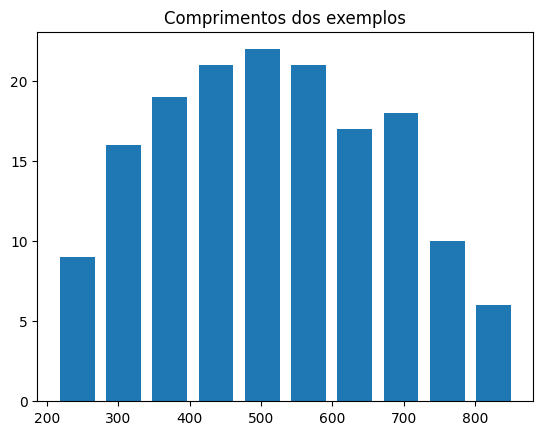

In [5]:
pyplot.title('Comprimentos dos exemplos')
lengths = numpy.array([len(segment) for segment in segments])
pyplot.hist(lengths, rwidth=0.75, bins=10)

pyplot.show()

['O', 'V', 'Z'] [42 37 40]
['O', 'V', 'Z'] [15 12 13]


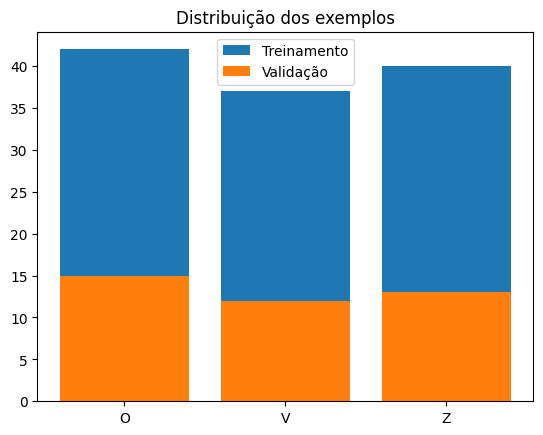

In [6]:
labels = list(one_hot_encoding.keys())

pyplot.title('Distribuição dos exemplos')

height =  numpy.histogram(y_train.argmax(axis=1), bins=len(labels))[0]
print(labels, height)
pyplot.bar(labels, height, label='Treinamento')

height =  numpy.histogram(y_test.argmax(axis=1), bins=len(labels))[0]
print(labels, height)
pyplot.bar(labels, height, label='Validação')

pyplot.legend()
pyplot.show()

In [8]:

# Defina a arquitetura da rede neural
model = models.Sequential()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=x_train.shape[1:]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(len(one_hot_encoding), activation='softmax'),
])

# Compile o modelo

model.compile(loss='categorical_crossentropy',
              metrics=['acc'])

# Treine o modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 28ms/step - loss: 1.1935 - acc: 0.3866 - val_loss: 1.0760 - val_acc: 0.5500
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0577 - acc: 0.4958 - val_loss: 1.0172 - val_acc: 0.5750
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0110 - acc: 0.5966 - val_loss: 0.9850 - val_acc: 0.6000
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9758 - acc: 0.6218 - val_loss: 0.9533 - val_acc: 0.6000
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9428 - acc: 0.5882 - val_loss: 0.9262 - val_acc: 0.6250
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9158 - acc: 0.6050 - val_loss: 0.9131 - val_acc: 0.6750
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 0.8953 - acc: 0.6303 - val_loss: 0.8821 - val_acc: 0.6750
Epoch 8/100
4/4 [==============================] - 0s 6ms/step - loss: 0.8722 - acc: 0.6387 - va

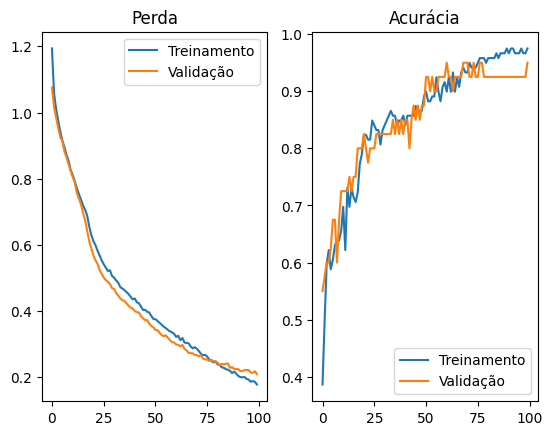

In [9]:
fig, ax = pyplot.subplots(1, 2)

ax[0].set_title('Perda')
ax[0].plot(history.epoch, history.history['loss'], label='Treinamento')
ax[0].plot(history.epoch, history.history['val_loss'], label='Validação')
ax[0].legend()

ax[1].set_title('Acurácia')
ax[1].plot(history.epoch, history.history['acc'], label='Treinamento')
ax[1].plot(history.epoch, history.history['val_acc'], label='Validação')
ax[1].legend()

pyplot.show()

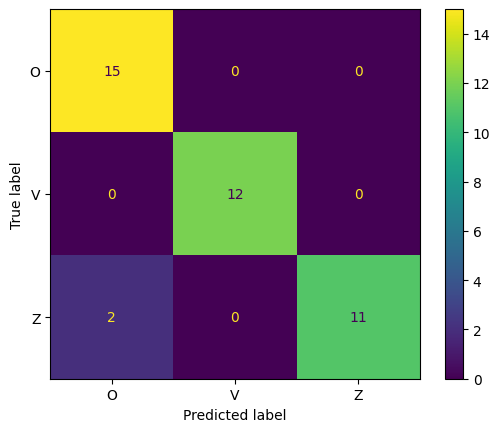

,O,V,Z,accuracy,macro avg,weighted avg
precision,0.882353,1.0,1.000000,0.95,0.960784,0.955882
recall,1.000000,1.0,0.846154,0.95,0.948718,0.950000
f1-score,0.937500,1.0,0.916667,0.95,0.951389,0.949479
support,15.000000,12.0,13.000000,0.95,40.000000,40.000000


In [10]:
y_pred = model.predict(x_test, verbose=0).argmax(axis=1)
y_true = y_test.argmax(axis=1)

labels = list(one_hot_encoding.keys())
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=None, display_labels=labels)
pyplot.show()

pandas.DataFrame.from_dict(classification_report(y_true, y_pred, target_names=labels, output_dict=True))

In [12]:
def calculate_model_size(model):
    print(model.summary())
    var_sizes = [
            numpy.product(list(map(int, v.shape))) * v.dtype.size
            for v in model.trainable_variables
    ]
    print("Model size:", sum(var_sizes) / 1024, "KB")


calculate_model_size(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 210)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2110      
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 2143 (8.37 KB)
Trainable params: 2143 (8.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model size: 8.37109375 KB


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("model_quantized.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

INFO:tensorflow:Assets written to: /tmp/tmpbevse2so/assets


INFO:tensorflow:Assets written to: /tmp/tmpbevse2so/assets
2024-03-26 22:28:03.605576: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-26 22:28:03.605606: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-26 22:28:03.605849: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbevse2so
2024-03-26 22:28:03.606241: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-03-26 22:28:03.606249: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpbevse2so
2024-03-26 22:28:03.607409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-03-26 22:28:03.607807: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-26 22:28:03.629282: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpp7sefx09/assets


INFO:tensorflow:Assets written to: /tmp/tmpp7sefx09/assets


Basic model is 10580 bytes
Quantized model is 4352 bytes
Difference is 6228 bytes


2024-03-26 22:28:04.115742: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-26 22:28:04.115762: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-26 22:28:04.115901: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp7sefx09
2024-03-26 22:28:04.116866: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-03-26 22:28:04.116879: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpp7sefx09
2024-03-26 22:28:04.118788: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-26 22:28:04.138359: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpp7sefx09
2024-03-26 22:28:04.146609: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 30707 m